# Sulcus Angle - Native 


### Points notation
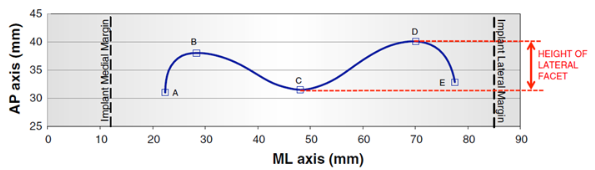

In [2]:
#Import libraries

import os
import vtk
import numpy as np
from vtkmodules.vtkCommonDataModel import vtkPlane
from vtkmodules.vtkFiltersCore import vtkCutter

### Folders for the Cuts and Logs:

In [ ]:
def CreateCutsFolder(NativeOrImplant):
    folder_path = os.path.join(os.getcwd(),'ANON')
    patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
    patients.sort(key=lambda x: int(x))
    legs=['Left','Right']
    os.mkdir(os.path.join(os.getcwd(),NativeOrImplant,'Cuts'))
    for p in range(len(patients)):
        os.mkdir(os.path.join(os.getcwd(),NativeOrImplant,'Cuts',patients[p]))
        for l in range(len(legs)): 
            if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
                os.mkdir(os.path.join(os.getcwd(),NativeOrImplant,'Cuts',patients[p],legs[l])) 

In [4]:
if not(os.path.exists(os.path.join(os.getcwd(),'Native'))):
    os.mkdir(os.path.join(os.getcwd(),'Native'))
    os.mkdir(os.path.join(os.getcwd(),'Native','Logs'))
    CreateCutsFolder('Native')
    
if not(os.path.exists(os.path.join(os.getcwd(),'Implant'))):
    os.mkdir(os.path.join(os.getcwd(),'Implant'))
    os.mkdir(os.path.join(os.getcwd(),'Implant','Logs'))
    CreateCutsFolder('Implant')

### Subprograms

In [5]:
#Read meshes VTK and STL

def LoadMesh(filename):
    reader = vtk.vtkPolyDataReader() 
    reader.SetFileName(filename)
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.Update()
    mesh = reader.GetOutput()  
    return mesh

def LoadMeshstl(filename):
    reader = vtk.vtkSTLReader()
    reader.SetFileName(filename)
    reader.Update()
    mesh = reader.GetOutput()  
    return mesh

In [6]:
#Rotate vectors around an axis

def rotate_vector(vector, axis, angle):
    # Convert angle to radians
    angle_rad = np.radians(angle)

    # Rotation matrix
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    rotation_matrix = np.outer(axis, axis) * (1 - cos_theta) + np.eye(3) * cos_theta + \
                      np.array([[0, -axis[2], axis[1]],
                                [axis[2], 0, -axis[0]],
                                [-axis[1], axis[0], 0]]) * sin_theta

    # Vector rotation
    rotated_vector = np.dot(rotation_matrix, vector)

    return rotated_vector

In [ ]:
#Create one cut at a certain angle of rotation, center and axis

def CutCreator(CenterRotationAxis,AxisNormal,RotationAxis,degrees,patient,leg,NativeOrImplant):

    AxisNormal=rotate_vector(AxisNormal, RotationAxis, degrees)
    # create a plane to cut,here it cuts in the XZ direction (xz normal=(1,0,0);XY =(0,0,1),YZ =(0,1,0)
    plane = vtkPlane()
    plane.SetOrigin(CenterRotationAxis)
    plane.SetNormal(AxisNormal)

    # create cutter
    cutter = vtkCutter()
    cutter.SetCutFunction(plane)
    cutter.SetInputData(ANONModel)
    cutter.Update()
    contorno=cutter.GetOutput() 

    #SaveCutter
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(os.path.join(os.getcwd(),NativeOrImplant,'Cuts',patient, leg, str(degrees)+'DegreesCut.vtk'))
    writer.SetInputData(contorno)
    writer.Write()

In [8]:
#Distance between 2 points

def calculate_distance(point1, point2):
    difference = point1 - point2
    distance = np.linalg.norm(difference)
    return distance

In [9]:
#Finding the angle between 3 points:

def SulcusAngle(B,C,D):
    vector2 = np.array(B) - np.array(C)
    vector1 = np.array(D) - np.array(C)

    producto_punto = np.dot(vector1, vector2)
    magnitud1 = np.linalg.norm(vector1)
    magnitud2 = np.linalg.norm(vector2)

    coseno_angulo = producto_punto / (magnitud1 * magnitud2)
    angulo_radianes = np.arccos(coseno_angulo)
    angulo_grados = np.degrees(angulo_radianes)
    
    return angulo_grados

In [10]:
#Find B,C,D for a particular cut

def BCDfinder(CutMeshFile,CenterRotationAxis,AxisNormal,RotationAxis,degrees,ReferenceLateralPoint,NativeOrImplant,leg):
    #B and D
    CutMesh=LoadMesh(os.path.join(CutMeshFile))
    AxisNormal=rotate_vector(AxisNormal, RotationAxis, degrees)
    FirstAxis =rotate_vector(AxisNormal, RotationAxis, 90) #AP A positive
    SecondAxis=rotate_vector(FirstAxis, AxisNormal, 90)   #ML L positive

    points=[]
    for i in range(CutMesh.GetNumberOfPoints()):
        point = CutMesh.GetPoint(i)
        points.append(point)

    points=np.array(points)

    distances=DistanceToPlane(points, CenterRotationAxis, FirstAxis)
    distances2=DistanceToPlane(points, CenterRotationAxis, SecondAxis)
    distances=np.array(distances)
    distances2=np.array(distances2)
    
    #print(distances)
    #print(distances2)

    Dindex=np.where(distances==(max(distances[distances2>=0])))[0] 
    D=points[Dindex][0]
    Bindex=np.where(distances==(max(distances[distances2<0])))[0]
    B=points[Bindex][0]
    

    if (calculate_distance(ReferenceLateralPoint,D)>(calculate_distance(ReferenceLateralPoint,B))) :
        A=B
        B=D
        D=A
        SecondAxis=-SecondAxis

    DistanceD=DistanceToPlane(points, D, -SecondAxis)
    DistanceB=DistanceToPlane(points, B, SecondAxis)
    DistanceD=np.array(DistanceD)
    DistanceB=np.array(DistanceB)
    
  
    
    Cindex=np.where(distances==(min(distances[(DistanceD>=0)&(DistanceB>=0)&(distances>=10)])))[0] 
    C=points[Cindex][0]    
    
    #    if leg=='Left':
    #    angletorotatesign=-1
    #else:
    #    angletorotatesign=1
    
    #angletorotate=30
    #DistanceD=DistanceToPlane(points, D, rotate_vector(-SecondAxis, AxisNormal, -angletorotatesign*angletorotate) )
    #DistanceB=DistanceToPlane(points, B, rotate_vector(SecondAxis, AxisNormal, angletorotatesign*angletorotate) )
    #DistanceD=np.array(DistanceD)
    #DistanceB=np.array(DistanceB)
    
    #Cindex=np.where(distances==(min(distances[(DistanceD>=0)&(DistanceB>=0)&(distances>=0)])))[0] 
    #C=points[Cindex][0]
        
    if NativeOrImplant=='Implant':
        distances3=DistanceToPlane(points, C, FirstAxis)
        distances3=np.array(distances3)
        normalize=DistanceToPlane([D], C, FirstAxis)[0]
        distances3=distances3/normalize
        Cindex=np.where(distances==(min(distances[(DistanceD>=0)&(DistanceB>=0)&(distances>=10)&(distances3>.55)])))[0] 
        C=points[Cindex][0]
        i=.56
        while (SulcusAngle(B,C,D)<110):
            Cindex=np.where(distances==(min(distances[(DistanceD>=0)&(DistanceB>=0)&(distances>=10)&(distances3>i)])))[0] 
            C=points[Cindex][0]
            i+=.01
    
    return B,C,D

In [11]:

# noinspection PyUnresolvedReferences
# import vtkmodules.vtkInteractionStyle
# # noinspection PyUnresolvedReferences
# import vtkmodules.vtkRenderingOpenGL2
# from vtkmodules.vtkCommonColor import vtkNamedColors
# from vtkmodules.vtkFiltersSources import vtkPlaneSource
# from vtkmodules.vtkRenderingCore import (
#     vtkActor,
#     vtkPolyDataMapper,
#     vtkRenderWindow,
#     vtkRenderWindowInteractor,
#     vtkRenderer
# )

#For points visualization:

def CreateSphere(route,S_center):
    
    sphereC = vtk.vtkSphereSource()
    sphereC.SetCenter(S_center)
    sphereC.SetRadius(1)

    sphereC.SetThetaResolution(50)
    sphereC.SetPhiResolution(50) 

    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(route)
    writer.SetInputConnection(sphereC.GetOutputPort())
    writer.Write()

    return

In [12]:
#Reading the resection plane Normal

def ReadNormalPlane(route):
    with open(route, 'r') as f:
        contenido = f.read()
        palabras = contenido.split()
        i = palabras.index('NORMALS')
        normalc=[]
        normalc.append(palabras[i+3])
        normalc.append(palabras[i+4])
        normalc.append(palabras[i+5])
        normal=[float(char) for char in normalc]
    return normal

In [13]:
#Returns a list with the distance between every point of the mesh and a plane

def DistanceToPlane(numpyPoints, origin, normal):
    distances = []
    for i in range(len(numpyPoints)):
        point = numpyPoints[i]
        dist = np.dot(np.array(point) - np.array(origin), np.array(normal))
        distances.append(dist)
    return distances

In [14]:
# Find the sulcus Height (Lateral and medial)

def SulcusHeight(B,C,D,degrees,RotationAxis,AxisNormal):
    AxisNormal=rotate_vector(AxisNormal, RotationAxis, degrees)
    FirstAxis =rotate_vector(AxisNormal, RotationAxis, 90)
    LateralSulcusHeight=DistanceToPlane([D], C, FirstAxis)[0]
    MedialSulcusHeight=DistanceToPlane([B], C, FirstAxis)[0]
    return LateralSulcusHeight,MedialSulcusHeight

In [ ]:
def ProthesisSphereCenterFinder(AnteriorResection,MedialMostPosterior,AnteriorResectionCenter,DistalResection,DistalResectionCenter):
    #Get the internal AP implant distance:
    #most posterior medial point distance to anterior resection plane +
    #config.medial_post_condyle_offset_from_sphere (cartilage thickness) mm (for this batch ANONmm) +
    #ANON mm for anterior thickness

    DistAntResMedMostDist=abs(DistanceToPlane([MedialMostPosterior], AnteriorResectionCenter, AnteriorResection)[0])
    
    APimplantDistance=DistAntResMedMostDist+ANON
    
    #the radius of the medial pivot is ANON this distance
    
    SpheresRadius=APimplantDistance/ANON

    #For the rotation I dont care about the exact point, only that it is in the line 
    #distance to the posterior Resection Plane = SpheresRadius - (ANON + ANON) mm
    #distance to the distal Resection Plane = SpheresRadius - (ANON + ANON) mm
    
    y=np.array(AnteriorResectionCenter + np.array(AnteriorResection)*(SpheresRadius-(ANON)))
    zDistance= abs(DistanceToPlane([y], DistalResectionCenter, DistalResection)[0])
    z=y-np.array(DistalResection)*zDistance
    CenterRotationAxis=z+np.array(DistalResection)*(SpheresRadius-(ANON))
   
    
    return CenterRotationAxis

In [16]:
def CopyVTKFile(mesh,path):
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(path)
    writer.SetInputData(mesh)
    writer.Write()
    return

def save_vtk_line_with_translation(filename, vector, center):
    # Normalizar el vector
    vector = vector / np.linalg.norm(vector)

    # Calcular los puntos de la línea
    point1 = center
    point2 = center + 35 * vector

    # Crear el objeto vtkLineSource
    line = vtk.vtkLineSource()
    line.SetPoint1(point1)
    line.SetPoint2(point2)

    # Guardar el archivo VTK
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(filename)
    writer.SetInputConnection(line.GetOutputPort())
    writer.Write()
    return

In [ ]:
#The angle between The normal of the distal resection plane and the vertical line defined by the Knee Middle plane
#This is to say the AxisNormal and KneeMiddleVector in the coronal plane (pl_Posterior resection)
#Knee middle vector is a vector defined by the 2 most anterior poirnts of the plane

def NTA(PosteriorResection,PosteriorResectionCenter,DistalResectionNormal,KneeMiddleMesh,patient,leg):
    CoronalPlane=PosteriorResection #AP A positive

    #Extract the 2 points in the Trochlea (2 most anterior)
    points=[]
    for i in range(KneeMiddleMesh.GetNumberOfPoints()):
        point = KneeMiddleMesh.GetPoint(i)
        points.append(point)
    
    points=np.array(points)
    distances=DistanceToPlane(points, PosteriorResectionCenter, PosteriorResection)
    distances=np.array(distances)
    
    Point1Index=np.where(distances==(max(distances)))[0] 
    Point1=points[Point1Index][0]
    
    distances=np.delete(distances,Point1Index)
    
    Point2Index=np.where(distances==(max(distances)))[0] 
    Point2=points[Point2Index][0]
    
    KneeMiddleVector=(np.array(Point1) - np.array(Point2))
    KneeMiddleVector=KneeMiddleVector/ np.linalg.norm(KneeMiddleVector)
    KneeMiddleVector=np.array(KneeMiddleVector)
    
    CoronalPlane=np.array(CoronalPlane)
    
    KneeMiddleVector=np.array(KneeMiddleVector)
    DistalResectionNormal=np.array(DistalResectionNormal)
    CoronalPlane=np.array(CoronalPlane)
    
    # Project KneeMiddle
    ProjectedKneeMiddle = KneeMiddleVector - np.dot(KneeMiddleVector, CoronalPlane) * CoronalPlane
    ProjectedKneeMiddle = ProjectedKneeMiddle / np.linalg.norm(ProjectedKneeMiddle)

    # Project DistalResectionNormal
    ProjectedDistalResectionNormal = DistalResectionNormal - np.dot(DistalResectionNormal, CoronalPlane) * CoronalPlane
    ProjectedDistalResectionNormal = ProjectedDistalResectionNormal / np.linalg.norm(ProjectedDistalResectionNormal)
    
    #Calculate angle
    
    # Calcular el ángulo en radianes utilizando el producto cruz
    cross_product = np.cross(ProjectedKneeMiddle,ProjectedDistalResectionNormal)
    NativeThrocleaAngle = np.arctan2(np.linalg.norm(cross_product), np.dot( ProjectedKneeMiddle,ProjectedDistalResectionNormal))
    
    # Convertir el ángulo a grados
    NativeThrocleaAngle = np.degrees(NativeThrocleaAngle)
    
    # Determinar el signo del ángulo utilizando el producto cruz
    cross_product= cross_product / np.linalg.norm(cross_product)
    CoronalPlane= CoronalPlane / np.linalg.norm(CoronalPlane)
    sign = np.sign(np.dot(cross_product, np.array(CoronalPlane))) 
    #print(np.linalg.norm(cross_product))
    
    #print((np.dot(cross_product, np.array(CoronalPlane))))
    
    NativeThrocleaAngle = NativeThrocleaAngle * sign
    if leg=='Right':
        NativeThrocleaAngle=-NativeThrocleaAngle
    
    #print('Patient: ',patient+' '+leg,'\nknee: ',ProjectedKneeMiddle,'\ndistal resection: ',ProjectedDistalResectionNormal,'\nangle: ',NativeThrocleaAngle,'\nCross Product: ', cross_product,'\n///////')
    
    #Imprimo vectore para verificar comportamiento,USAR VISUALIZACION PARA EXPLICAR CODIGO
    #save_vtk_line_with_translation(os.path.join(os.getcwd(),'Native', 'Cuts',patient,leg,'DistalResectionNormal.vtk'), DistalResectionNormal, Point2)
    #save_vtk_line_with_translation(os.path.join(os.getcwd(),'Native', 'Cuts',patient,leg,'KneeMiddleVector.vtk'), KneeMiddleVector, Point2)
    
    #save_vtk_line_with_translation(os.path.join(os.getcwd(),'Native', 'Cuts',patient,leg,'ProjectedDistalResectionNormal.vtk'), ProjectedDistalResectionNormal, PosteriorResectionCenter)
    #save_vtk_line_with_translation(os.path.join(os.getcwd(),'Native', 'Cuts',patient,leg,'ProjectedKneeMiddle.vtk'), ProjectedKneeMiddle, PosteriorResectionCenter)
    
    return NativeThrocleaAngle

In [104]:
print(np.dot(cross_product, np.array(PosteriorResection))

SyntaxError: unexpected EOF while parsing (2873748728.py, line 1)

# NATIVE MAIN

In [ ]:
#Main 

# Vectors to save the data and make the statistics

SulcusAngle0=[]
SulcusAngle15=[]
SulcusAngle30=[]
SulcusAngle45=[]

LateralSulcusHeight0=[]
LateralSulcusHeight15=[]
LateralSulcusHeight30=[]
LateralSulcusHeight45=[]

MedialSulcusHeight0=[]
MedialSulcusHeight15=[]
MedialSulcusHeight30=[]
MedialSulcusHeight45=[]

NTAanalysis=[]

#Go over all patients

folder_p = os.path.join(os.getcwd(),'ANON') #Folders with the patients
folder_path = os.path.join(os.getcwd(),folder_p)
patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
patients.sort(key=lambda x: int(x))
legs=['Left','Right']
for p in range(len(patients)):
    for l in range(len(legs)): 
        if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
            if os.path.exists(os.path.join(folder_path,patients[p],legs[l],'ANON','ANON','ANON')):       
                
                #Rotation axis (Primary axis)
                
                RotationAxisRoute=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','ax_Primary.vtk')
                RotationAxis=LoadMesh(os.path.join(RotationAxisRoute))
                
                #ANON model to cut
                
                ANONModelRoute=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'segmentation','ANON.stl')
                ANONModel=LoadMeshstl(os.path.join(ANONModelRoute))
                
                #Reference to choose which is B or D
                
                ReferenceLateralPoint=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pt_Lateral most anterior.vtk')
                ReferenceLateralPoint=LoadMesh(os.path.join(ReferenceLateralPoint))
                ReferenceLateralPoint=np.array(ReferenceLateralPoint.GetCenter())
                
                #Resection plan to rotate
                
                AxisNormal=ReadNormalPlane((os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Distal resection.vtk')))
                
                
                #Find the center of the implant spheres to use as th center of the rotation of the planes
                
                #Loading the necessary axis and points
                
                AnteriorResection=ReadNormalPlane((os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Anterior resection.vtk')))
                
                AnteriorResectionCenter=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Anterior resection.vtk')
                AnteriorResectionCenter=LoadMesh(os.path.join(AnteriorResectionCenter))
                AnteriorResectionCenter=np.array(AnteriorResectionCenter.GetCenter())
                
                DistalResectionCenter=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Distal resection.vtk')
                DistalResectionCenter=LoadMesh(os.path.join(DistalResectionCenter))
                DistalResectionCenter=np.array(DistalResectionCenter.GetCenter())
                
                MedialMostPosterior=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pt_Medial most posterior.vtk')
                MedialMostPosterior=LoadMesh(os.path.join(MedialMostPosterior))
                MedialMostPosterior=np.array(MedialMostPosterior.GetCenter())
                
                PosteriorResection=ReadNormalPlane((os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Posterior resection.vtk')))

                PosteriorResectionCenter=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Posterior resection.vtk')
                PosteriorResectionCenter=LoadMesh(os.path.join(PosteriorResectionCenter))
                PosteriorResectionCenter=np.array(PosteriorResectionCenter.GetCenter())
                #The order of the rotation axis points is inverted depending on the leg
                #The Normal of the Resection plane is inverted depending on the leg
                
                if legs[l]=='Left':
                    RotationAxis=-(np.array(RotationAxis.GetPoint(0)) - np.array(RotationAxis.GetPoint(1)))
                    RotationAxis=RotationAxis/ np.linalg.norm(RotationAxis)

                    AxisNormal=[-x for x in AxisNormal] 
                    AnteriorResection=[-x for x in AnteriorResection]
                    
                    
                    
                else:
                    RotationAxis=(np.array(RotationAxis.GetPoint(0)) - np.array(RotationAxis.GetPoint(1)))
                    RotationAxis=RotationAxis/ np.linalg.norm(RotationAxis)
                    PosteriorResection=[-x for x in PosteriorResection]
                    
                #Finding the NTA for the native ANON                
                
                #NTA will be the angle between 'pl_Knee middle' and 'pl_Distal resection.vtk' in the coronal plane: 'pl_Posterior resection' 
                KneeMiddle=LoadMesh((os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Knee middle.vtk')))
                
                NativeThrocleaAngle=NTA(PosteriorResection,PosteriorResectionCenter,AxisNormal,KneeMiddle,patients[p],legs[l]) 
                NTAanalysis.append(NativeThrocleaAngle)
                
                #Finding the center
                CenterRotationAxis= ProthesisSphereCenterFinder(AnteriorResection,MedialMostPosterior,AnteriorResectionCenter,AxisNormal,DistalResectionCenter)
                
                #Make a ANON copy for visualization
                CopyVTKFile(ANONModel,os.path.join(os.getcwd(),'Native','Cuts',patients[p],legs[l],'ANON.vtk'))
 
                #Choose the degrees for the cuts
                
                degrees= [0,15,30,45]
                for d in degrees:   
                    
                    #Create the cut
                    CutCreator(CenterRotationAxis,AxisNormal,RotationAxis,d,patients[p],legs[l],'Native')
                    
                    #Find the sulcus angle, B,C,D in that cut
                    CutMeshFile=os.path.join(os.getcwd(),'Native','Cuts',patients[p],legs[l],str(d)+'DegreesCut.vtk')
                    CutMesh=LoadMesh(os.path.join(CutMeshFile))

                    B,C,D=BCDfinder(CutMeshFile,CenterRotationAxis,AxisNormal,RotationAxis,d,ReferenceLateralPoint,'Native',legs[l])
                    sulcus_deg=SulcusAngle(B,C,D)
                    
                    #Measure the Sulcus Height
                    LateralSulcusHeight,MedialSulcusHeight=SulcusHeight(B,C,D,d,RotationAxis,AxisNormal)

                    #Add the informations to the vector for making the statistics
                    if d==0:
                        SulcusAngle0.append(sulcus_deg)
                        LateralSulcusHeight0.append(LateralSulcusHeight)
                        MedialSulcusHeight0.append(MedialSulcusHeight)
                    if d==15:
                        SulcusAngle15.append(sulcus_deg)
                        LateralSulcusHeight15.append(LateralSulcusHeight)
                        MedialSulcusHeight15.append(MedialSulcusHeight)
                    if d==30:
                        SulcusAngle30.append(sulcus_deg)
                        LateralSulcusHeight30.append(LateralSulcusHeight)
                        MedialSulcusHeight30.append(MedialSulcusHeight)
                    if d==45:
                        SulcusAngle45.append(sulcus_deg)
                        LateralSulcusHeight45.append(LateralSulcusHeight)
                        MedialSulcusHeight45.append(MedialSulcusHeight)
                    
                    #Create spheres for visualization of points B,C,D
                    CreateSphere(os.path.join(os.getcwd(),'Native','Cuts',patients[p],legs[l],'B_'+str(d)+'.vtk'),B)
                    CreateSphere(os.path.join(os.getcwd(),'Native','Cuts',patients[p],legs[l],'C_'+str(d)+'.vtk'),C)
                    CreateSphere(os.path.join(os.getcwd(),'Native','Cuts',patients[p],legs[l],'D_'+str(d)+'.vtk'),D)
                    
                    #Save the info of each for analysis
                    with open (os.path.join(os.getcwd(),'Native','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:
                        f.write("Points:"+" \n")
                        f.write("B:"+str(np.round(B,1))+" \n")
                        f.write("C:"+str(np.round(C,1))+" \n")
                        f.write("D:"+str(np.round(D,1))+" \n")
                        f.write("Sulcus Angle: "+str(round(sulcus_deg,1))+" º \n")
                        f.write("Lateral Sulcus Height: "+str(round(LateralSulcusHeight,1))+" mm \n")
                        f.write("Medial Sulcus Height: "+str(round(MedialSulcusHeight,1))+" mm \n")
                        f.write("NativeThrocleaAngle (NTA) : "+str(round(NativeThrocleaAngle,1))+" º \n")
            else:
                with open (os.path.join(os.getcwd(),'Native','Cuts',patients[p],legs[l],'NO_ANON_MODEL'+".txt"),"w") as f:
                        f.write("NO ANON MODEL"+" \n")
                degrees= [0,15,30,45]
                for d in degrees: 
                    with open (os.path.join(os.getcwd(),'Native','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:
                            f.write("NO ANON MODEL"+" \n")


In [ ]:
KneeMiddle=ReadNormalPlane((os.path.join(os.getcwd(),'ANON','ANON','Left','ANON','ANON','ANON','pl_Knee middle.vtk')))
print('Left: ',KneeMiddle)

KneeMiddle=ReadNormalPlane((os.path.join(os.getcwd(),'ANON','ANON','Right','ANON','ANON','ANON','pl_Knee middle.vtk')))
print('Right: ',KneeMiddle)

print('/////////')

PosteriorResection=ReadNormalPlane((os.path.join(os.getcwd(),'ANON','ANON','Left','ANON','ANON','ANON','pl_Posterior resection.vtk')))
print('Left: ',PosteriorResection)

PosteriorResection=ReadNormalPlane((os.path.join(os.getcwd(),'ANON','ANON','Right','ANON','ANON','ANON','pl_Posterior resection.vtk')))
print('Right: ',PosteriorResection)

Left:  [0.991779, 0.018236, -0.126656]
Right:  [0.990094, -0.0896611, 0.108047]
/////////
Left:  [0.0181254, -0.999798, 0.00872429]
Right:  [0.0933112, 0.995632, -0.00300818]


In [120]:
#Make the statistics

SulcusAngle0=np.array(SulcusAngle0)
SulcusAngle15=np.array(SulcusAngle15) 
SulcusAngle30=np.array(SulcusAngle30)
SulcusAngle45=np.array(SulcusAngle45)

Mean_0 = np.mean(SulcusAngle0)
SD_0 =np.std(SulcusAngle0)
Max_0 = np.max(SulcusAngle0)
Min_0 = np.min(SulcusAngle0)

Mean_15 = np.mean(SulcusAngle15)
SD_15 =np.std(SulcusAngle15)
Max_15 = np.max(SulcusAngle15)
Min_15 = np.min(SulcusAngle15)

Mean_30 = np.mean(SulcusAngle30)
SD_30 =np.std(SulcusAngle30)
Max_30 = np.max(SulcusAngle30)
Min_30 = np.min(SulcusAngle30)

Mean_45 = np.mean(SulcusAngle45)
SD_45 =np.std(SulcusAngle45)
Max_45 = np.max(SulcusAngle45)
Min_45 = np.min(SulcusAngle45)

LateralSulcusHeight0=np.array(LateralSulcusHeight0)
LateralSulcusHeight15=np.array(LateralSulcusHeight15)
LateralSulcusHeight30=np.array(LateralSulcusHeight30)
LateralSulcusHeight45=np.array(LateralSulcusHeight45)

MedialSulcusHeight0=np.array(MedialSulcusHeight0)
MedialSulcusHeight15=np.array(MedialSulcusHeight15)
MedialSulcusHeight30=np.array(MedialSulcusHeight30)
MedialSulcusHeight45=np.array(MedialSulcusHeight45)

Lateral_Mean_0 = np.mean(LateralSulcusHeight0)
Lateral_SD_0 =np.std(LateralSulcusHeight0)
Lateral_Max_0 = np.max(LateralSulcusHeight0)
Lateral_Min_0 = np.min(LateralSulcusHeight0)

Lateral_Mean_15 = np.mean(LateralSulcusHeight15)
Lateral_SD_15 =np.std(LateralSulcusHeight15)
Lateral_Max_15 = np.max(LateralSulcusHeight15)
Lateral_Min_15 = np.min(LateralSulcusHeight15)

Lateral_Mean_30 = np.mean(LateralSulcusHeight30)
Lateral_SD_30 =np.std(LateralSulcusHeight30)
Lateral_Max_30 = np.max(LateralSulcusHeight30)
Lateral_Min_30 = np.min(LateralSulcusHeight30)

Lateral_Mean_45 = np.mean(LateralSulcusHeight45)
Lateral_SD_45 =np.std(LateralSulcusHeight45)
Lateral_Max_45 = np.max(LateralSulcusHeight45)
Lateral_Min_45 = np.min(LateralSulcusHeight45)

Medial_Mean_0 = np.mean(MedialSulcusHeight0)
Medial_SD_0 =np.std(MedialSulcusHeight0)
Medial_Max_0 = np.max(MedialSulcusHeight0)
Medial_Min_0 = np.min(MedialSulcusHeight0)

Medial_Mean_15 = np.mean(MedialSulcusHeight15)
Medial_SD_15 =np.std(MedialSulcusHeight15)
Medial_Max_15 = np.max(MedialSulcusHeight15)
Medial_Min_15 = np.min(MedialSulcusHeight15)

Medial_Mean_30 = np.mean(MedialSulcusHeight30)
Medial_SD_30 =np.std(MedialSulcusHeight30)
Medial_Max_30 = np.max(MedialSulcusHeight30)
Medial_Min_30 = np.min(MedialSulcusHeight30)

Medial_Mean_45 = np.mean(MedialSulcusHeight45)
Medial_SD_45 =np.std(MedialSulcusHeight45)
Medial_Max_45 = np.max(MedialSulcusHeight45)
Medial_Min_45 = np.min(MedialSulcusHeight45)

with open (os.path.join(os.getcwd(),'Native','Average_SuclcusAngle'+".txt"),"w") as f:
    f.write("0º:"+" \n")
    f.write("Average: "+str(round(Mean_0, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_0, 1))+"\n")
    f.write("Max: "+str(round(Max_0, 1))+"\n")
    f.write("Min: "+str(round(Min_0, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("15º:"+" \n")
    f.write("Average: "+str(round(Mean_15, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_15, 1))+"\n")
    f.write("Max: "+str(round(Max_15, 1))+"\n")
    f.write("Min: "+str(round(Min_15, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("30º:"+" \n")
    f.write("Average: "+str(round(Mean_30, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_30, 1))+"\n")
    f.write("Max: "+str(round(Max_30, 1))+"\n")
    f.write("Min: "+str(round(Min_30, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("45º:"+" \n")
    f.write("Average: "+str(round(Mean_45, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_45, 1))+"\n")
    f.write("Max: "+str(round(Max_45, 1))+"\n")
    f.write("Min: "+str(round(Min_45, 1))+"\n")
    

with open (os.path.join(os.getcwd(),'Native','LateralSulcusHeight'+".txt"),"w") as f:
    f.write("Lateral Sulcus Height:"+" \n")
    f.write("0º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_0, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_0, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_0, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_0, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("15º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_15, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_15, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_15, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_15, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("30º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_30, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_30, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_30, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_30, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("45º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_45, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_45, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_45, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_45, 1))+"\n")
    

with open (os.path.join(os.getcwd(),'Native','MedialSulcusHeight'+".txt"),"w") as f:  
    f.write("Medial Sulcus Height:"+" \n")
    f.write("0º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_0, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_0, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_0, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_0, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("15º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_15, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_15, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_15, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_15, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("30º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_30, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_30, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_30, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_30, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("45º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_45, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_45, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_45, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_45, 1))+"\n")
    
NTAanalysis_Mean = np.mean(NTAanalysis)
NTAanalysis_SD =np.std(NTAanalysis)
NTAanalysis_Max = np.max(NTAanalysis)
NTAanalysis_Min = np.min(NTAanalysis)   
    
with open (os.path.join(os.getcwd(),'Native','Native Trochlea Angle'+".txt"),"w") as f:  
    f.write("Native Trochlea Angle (NTA):"+" \n")
    f.write("Average: "+str(round(NTAanalysis_Mean, 1))+"\n")
    f.write("Standar Deviation: "+str(round(NTAanalysis_SD, 1))+"\n")
    f.write("Max: "+str(round(NTAanalysis_Max, 1))+"\n")
    f.write("Min: "+str(round(NTAanalysis_Min, 1))+"\n")


In [121]:
print([round(elemento) for elemento in NTAanalysis])

[7, 6, 3, 9, 10, 12, 14, 9, 10, 5, 6, 4, 6, 8, 12, 7, 6, 9, 6, 6, 9, 5, 7, 4, 8, 8, 9, 7, 10, 5, 7, 8, 7]


# IMPLANT MAIN

In [ ]:
#Main 

# Vectors to save the data and make the statistics

SulcusAngle0=[]
SulcusAngle15=[]
SulcusAngle30=[]
SulcusAngle45=[]

LateralSulcusHeight0=[]
LateralSulcusHeight15=[]
LateralSulcusHeight30=[]
LateralSulcusHeight45=[]

MedialSulcusHeight0=[]
MedialSulcusHeight15=[]
MedialSulcusHeight30=[]
MedialSulcusHeight45=[]

#Go over all patients

folder_p = os.path.join(os.getcwd(),'ANON') #Folders with the patients
folder_path = os.path.join(os.getcwd(),folder_p)
patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
patients.sort(key=lambda x: int(x))
legs=['Left','Right']
for p in range(len(patients)):
    for l in range(len(legs)): 
        if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
            if os.path.exists(os.path.join(folder_path,patients[p],legs[l],'ANON','ANON','ANON')):       
                if os.path.exists(os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON.stl')):   
                    #Rotation axis (Primary axis)

                    RotationAxisRoute=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','ax_Primary.vtk')
                    RotationAxis=LoadMesh(os.path.join(RotationAxisRoute))

                    #Implant model to cut

                    ANONModelRoute=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON.stl')
                    ANONModel=LoadMeshstl(os.path.join(ANONModelRoute))

                    #Reference to choose which is B or D

                    ReferenceLateralPoint=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pt_Lateral most anterior.vtk')
                    ReferenceLateralPoint=LoadMesh(os.path.join(ReferenceLateralPoint))
                    ReferenceLateralPoint=np.array(ReferenceLateralPoint.GetCenter())

                    #Resection plan to rotate

                    AxisNormal=ReadNormalPlane((os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Distal resection.vtk')))


                    #Find the center of the implant spheres to use as th center of the rotation of the planes

                    #Loading the necessary axis and points

                    AnteriorResection=ReadNormalPlane((os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Anterior resection.vtk')))

                    AnteriorResectionCenter=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Anterior resection.vtk')
                    AnteriorResectionCenter=LoadMesh(os.path.join(AnteriorResectionCenter))
                    AnteriorResectionCenter=np.array(AnteriorResectionCenter.GetCenter())

                    DistalResectionCenter=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pl_Distal resection.vtk')
                    DistalResectionCenter=LoadMesh(os.path.join(DistalResectionCenter))
                    DistalResectionCenter=np.array(DistalResectionCenter.GetCenter())

                    MedialMostPosterior=os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON','ANON','ANON','pt_Medial most posterior.vtk')
                    MedialMostPosterior=LoadMesh(os.path.join(MedialMostPosterior))
                    MedialMostPosterior=np.array(MedialMostPosterior.GetCenter())
                    
                    #Make an implant copy for visualization
                    CopyVTKFile(ANONModel,os.path.join(os.getcwd(),'Implant','Cuts',patients[p],legs[l],'ANON.vtk'))
                    

                    #The order of the rotation axis points is inverted depending on the leg
                    #The Normal of the Resection plane is inverted depending on the leg

                    if legs[l]=='Left':
                        RotationAxis=-(np.array(RotationAxis.GetPoint(0)) - np.array(RotationAxis.GetPoint(1)))
                        RotationAxis=RotationAxis/ np.linalg.norm(RotationAxis)

                        AxisNormal=[-x for x in AxisNormal] 
                        AnteriorResection=[-x for x in AnteriorResection]

                    else:
                        RotationAxis=(np.array(RotationAxis.GetPoint(0)) - np.array(RotationAxis.GetPoint(1)))
                        RotationAxis=RotationAxis/ np.linalg.norm(RotationAxis)

                    #Finding the center
                    CenterRotationAxis= ProthesisSphereCenterFinder(AnteriorResection,MedialMostPosterior,AnteriorResectionCenter,AxisNormal,DistalResectionCenter)
                    
                    #Choose the degrees for the cuts

                    degrees= [0,15,30,45]
                    for d in degrees:   

                        #Create the cut
                        CutCreator(CenterRotationAxis,AxisNormal,RotationAxis,d,patients[p],legs[l],'Implant')
                        #Find the sulcus angle, B,C,D in that cut
                        CutMeshFile=os.path.join(os.getcwd(),'Implant','Cuts',patients[p],legs[l],str(d)+'DegreesCut.vtk')
                        CutMesh=LoadMesh(os.path.join(CutMeshFile))

                        B,C,D=BCDfinder(CutMeshFile,CenterRotationAxis,AxisNormal,RotationAxis,d,ReferenceLateralPoint,'Implant',legs[l])
                        sulcus_deg=SulcusAngle(B,C,D)

                        #Measure the Sulcus Height
                        LateralSulcusHeight,MedialSulcusHeight=SulcusHeight(B,C,D,d,RotationAxis,AxisNormal)

                        #Add the informations to the vector for making the statistics
                        if d==0:
                            SulcusAngle0.append(sulcus_deg)
                            LateralSulcusHeight0.append(LateralSulcusHeight)
                            MedialSulcusHeight0.append(MedialSulcusHeight)
                        if d==15:
                            SulcusAngle15.append(sulcus_deg)
                            LateralSulcusHeight15.append(LateralSulcusHeight)
                            MedialSulcusHeight15.append(MedialSulcusHeight)
                        if d==30:
                            SulcusAngle30.append(sulcus_deg)
                            LateralSulcusHeight30.append(LateralSulcusHeight)
                            MedialSulcusHeight30.append(MedialSulcusHeight)
                        if d==45:
                            SulcusAngle45.append(sulcus_deg)
                            LateralSulcusHeight45.append(LateralSulcusHeight)
                            MedialSulcusHeight45.append(MedialSulcusHeight)

                        #Create spheres for visualization of points B,C,D
                        CreateSphere(os.path.join(os.getcwd(),'Implant','Cuts',patients[p],legs[l],'B_'+str(d)+'.vtk'),B)
                        CreateSphere(os.path.join(os.getcwd(),'Implant','Cuts',patients[p],legs[l],'C_'+str(d)+'.vtk'),C)
                        CreateSphere(os.path.join(os.getcwd(),'Implant','Cuts',patients[p],legs[l],'D_'+str(d)+'.vtk'),D)

                        #Save the info of each for analysis
                        with open (os.path.join(os.getcwd(),'Implant','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:
                            f.write("Points:"+" \n")
                            f.write("B:"+str(np.round(B,1))+" \n")
                            f.write("C:"+str(np.round(C,1))+" \n")
                            f.write("D:"+str(np.round(D,1))+" \n")
                            f.write("Sulcus Angle: "+str(round(sulcus_deg,1))+" º \n")
                            f.write("Lateral Sulcus Height: "+str(round(LateralSulcusHeight,1))+" mm \n")
                            f.write("Medial Sulcus Height: "+str(round(MedialSulcusHeight,1))+" mm \n")
                
                else:
                    with open (os.path.join(os.getcwd(),'Implant','Cuts',patients[p],legs[l],'NO_IMPLANT_MODEL'+".txt"),"w") as f:
                         f.write("NO IMPLANT MODEL"+" \n")
                    degrees= [0,15,30,45]
                    for d in degrees: 
                        with open (os.path.join(os.getcwd(),'Implant','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:
                                   f.write("NO IMPLANT MODEL"+" \n") 
                    
            else:
                with open (os.path.join(os.getcwd(),'Implant','Cuts',patients[p],legs[l],'NO_ANON_MODEL'+".txt"),"w") as f:
                        f.write("NO ANON MODEL"+" \n")
                degrees= [0,15,30,45]
                for d in degrees: 
                    with open (os.path.join(os.getcwd(),'Implant','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:
                            f.write("NO ANON MODEL"+" \n")
                

In [21]:
#Make the statistics

SulcusAngle0=np.array(SulcusAngle0)
SulcusAngle15=np.array(SulcusAngle15) 
SulcusAngle30=np.array(SulcusAngle30)
SulcusAngle45=np.array(SulcusAngle45)

Mean_0 = np.mean(SulcusAngle0)
SD_0 =np.std(SulcusAngle0)
Max_0 = np.max(SulcusAngle0)
Min_0 = np.min(SulcusAngle0)

Mean_15 = np.mean(SulcusAngle15)
SD_15 =np.std(SulcusAngle15)
Max_15 = np.max(SulcusAngle15)
Min_15 = np.min(SulcusAngle15)

Mean_30 = np.mean(SulcusAngle30)
SD_30 =np.std(SulcusAngle30)
Max_30 = np.max(SulcusAngle30)
Min_30 = np.min(SulcusAngle30)

Mean_45 = np.mean(SulcusAngle45)
SD_45 =np.std(SulcusAngle45)
Max_45 = np.max(SulcusAngle45)
Min_45 = np.min(SulcusAngle45)

LateralSulcusHeight0=np.array(LateralSulcusHeight0)
LateralSulcusHeight15=np.array(LateralSulcusHeight15)
LateralSulcusHeight30=np.array(LateralSulcusHeight30)
LateralSulcusHeight45=np.array(LateralSulcusHeight45)

MedialSulcusHeight0=np.array(MedialSulcusHeight0)
MedialSulcusHeight15=np.array(MedialSulcusHeight15)
MedialSulcusHeight30=np.array(MedialSulcusHeight30)
MedialSulcusHeight45=np.array(MedialSulcusHeight45)

Lateral_Mean_0 = np.mean(LateralSulcusHeight0)
Lateral_SD_0 =np.std(LateralSulcusHeight0)
Lateral_Max_0 = np.max(LateralSulcusHeight0)
Lateral_Min_0 = np.min(LateralSulcusHeight0)

Lateral_Mean_15 = np.mean(LateralSulcusHeight15)
Lateral_SD_15 =np.std(LateralSulcusHeight15)
Lateral_Max_15 = np.max(LateralSulcusHeight15)
Lateral_Min_15 = np.min(LateralSulcusHeight15)

Lateral_Mean_30 = np.mean(LateralSulcusHeight30)
Lateral_SD_30 =np.std(LateralSulcusHeight30)
Lateral_Max_30 = np.max(LateralSulcusHeight30)
Lateral_Min_30 = np.min(LateralSulcusHeight30)

Lateral_Mean_45 = np.mean(LateralSulcusHeight45)
Lateral_SD_45 =np.std(LateralSulcusHeight45)
Lateral_Max_45 = np.max(LateralSulcusHeight45)
Lateral_Min_45 = np.min(LateralSulcusHeight45)

Medial_Mean_0 = np.mean(MedialSulcusHeight0)
Medial_SD_0 =np.std(MedialSulcusHeight0)
Medial_Max_0 = np.max(MedialSulcusHeight0)
Medial_Min_0 = np.min(MedialSulcusHeight0)

Medial_Mean_15 = np.mean(MedialSulcusHeight15)
Medial_SD_15 =np.std(MedialSulcusHeight15)
Medial_Max_15 = np.max(MedialSulcusHeight15)
Medial_Min_15 = np.min(MedialSulcusHeight15)

Medial_Mean_30 = np.mean(MedialSulcusHeight30)
Medial_SD_30 =np.std(MedialSulcusHeight30)
Medial_Max_30 = np.max(MedialSulcusHeight30)
Medial_Min_30 = np.min(MedialSulcusHeight30)

Medial_Mean_45 = np.mean(MedialSulcusHeight45)
Medial_SD_45 =np.std(MedialSulcusHeight45)
Medial_Max_45 = np.max(MedialSulcusHeight45)
Medial_Min_45 = np.min(MedialSulcusHeight45)

with open (os.path.join(os.getcwd(),'Implant','Average_SuclcusAngle'+".txt"),"w") as f:
    f.write("0º:"+" \n")
    f.write("Average: "+str(round(Mean_0, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_0, 1))+"\n")
    f.write("Max: "+str(round(Max_0, 1))+"\n")
    f.write("Min: "+str(round(Min_0, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("15º:"+" \n")
    f.write("Average: "+str(round(Mean_15, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_15, 1))+"\n")
    f.write("Max: "+str(round(Max_15, 1))+"\n")
    f.write("Min: "+str(round(Min_15, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("30º:"+" \n")
    f.write("Average: "+str(round(Mean_30, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_30, 1))+"\n")
    f.write("Max: "+str(round(Max_30, 1))+"\n")
    f.write("Min: "+str(round(Min_30, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("45º:"+" \n")
    f.write("Average: "+str(round(Mean_45, 1))+"\n")
    f.write("Standar Deviation: "+str(round(SD_45, 1))+"\n")
    f.write("Max: "+str(round(Max_45, 1))+"\n")
    f.write("Min: "+str(round(Min_45, 1))+"\n")
    

with open (os.path.join(os.getcwd(),'Implant','LateralSulcusHeight'+".txt"),"w") as f:
    f.write("Lateral Sulcus Height:"+" \n")
    f.write("0º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_0, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_0, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_0, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_0, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("15º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_15, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_15, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_15, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_15, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("30º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_30, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_30, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_30, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_30, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("45º:"+" \n")
    f.write("Average: "+str(round(Lateral_Mean_45, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Lateral_SD_45, 1))+"\n")
    f.write("Max: "+str(round(Lateral_Max_45, 1))+"\n")
    f.write("Min: "+str(round(Lateral_Min_45, 1))+"\n")
    

with open (os.path.join(os.getcwd(),'Implant','MedialSulcusHeight'+".txt"),"w") as f:  
    f.write("Medial Sulcus Height:"+" \n")
    f.write("0º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_0, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_0, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_0, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_0, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("15º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_15, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_15, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_15, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_15, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("30º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_30, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_30, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_30, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_30, 1))+"\n")
    f.write(" \n")
    f.write(" \n")
    f.write("45º:"+" \n")
    f.write("Average: "+str(round(Medial_Mean_45, 1))+"\n")
    f.write("Standar Deviation: "+str(round(Medial_SD_45, 1))+"\n")
    f.write("Max: "+str(round(Medial_Max_45, 1))+"\n")
    f.write("Min: "+str(round(Medial_Min_45, 1))+"\n")

# Analysis

In [86]:
if not(os.path.exists(os.path.join(os.getcwd(),'Analysis'))):    
    os.mkdir(os.path.join(os.getcwd(),'Analysis'))

if not(os.path.exists(os.path.join(os.getcwd(),'Analysis','Native Average'))):    
    os.mkdir(os.path.join(os.getcwd(),'Analysis','Native Average'))
    
if not(os.path.exists(os.path.join(os.getcwd(),'Analysis','Implant Average'))):    
    os.mkdir(os.path.join(os.getcwd(),'Analysis','Implant Average'))

if not(os.path.exists(os.path.join(os.getcwd(),'Analysis','Logs'))):    
    os.mkdir(os.path.join(os.getcwd(),'Analysis','Logs'))

In [87]:
def CopyFile(direccion_a, direccion_b):

    with open(direccion_a, 'r') as archivo_a:
        content = archivo_a.read()

    with open(direccion_b, 'w') as archivo_b:
        archivo_b.write(content)

In [24]:
CopyFile(os.path.join(os.getcwd(),'Implant','Average_SuclcusAngle'+".txt"), os.path.join(os.getcwd(),'Analysis','Implant Average','SuclcusAngle'+".txt"))
CopyFile(os.path.join(os.getcwd(),'Implant','LateralSulcusHeight'+".txt"), os.path.join(os.getcwd(),'Analysis','Implant Average','LateralSulcusHeight'+".txt"))
CopyFile(os.path.join(os.getcwd(),'Implant','MedialSulcusHeight'+".txt"), os.path.join(os.getcwd(),'Analysis','Implant Average','MedialSulcusHeight'+".txt"))

CopyFile(os.path.join(os.getcwd(),'Native','Average_SuclcusAngle'+".txt"), os.path.join(os.getcwd(),'Analysis','Native Average','SuclcusAngle'+".txt"))
CopyFile(os.path.join(os.getcwd(),'Native','LateralSulcusHeight'+".txt"), os.path.join(os.getcwd(),'Analysis','Native Average','LateralSulcusHeight'+".txt"))
CopyFile(os.path.join(os.getcwd(),'Native','MedialSulcusHeight'+".txt"), os.path.join(os.getcwd(),'Analysis','Native Average','MedialSulcusHeight'+".txt"))


In [ ]:
#Vectors to save the differences

DifferenceSulcusAngle0=[]
DifferenceSulcusAngle15=[]
DifferenceSulcusAngle30=[]
DifferenceSulcusAngle45=[]

DifferenceLateralSulcusHeight0=[]
DifferenceLateralSulcusHeight15=[]
DifferenceLateralSulcusHeight30=[]
DifferenceLateralSulcusHeight45=[]

DifferenceMedialSulcusHeight0=[]
DifferenceMedialSulcusHeight15=[]
DifferenceMedialSulcusHeight30=[]
DifferenceMedialSulcusHeight45=[]

#

folder_p = os.path.join(os.getcwd(),'ANON') #Folders with the patients
folder_path = os.path.join(os.getcwd(),folder_p)
patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
patients.sort(key=lambda x: int(x))
legs=['Left','Right']
for p in range(len(patients)):
    for l in range(len(legs)): 
        if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
            if os.path.exists(os.path.join(folder_path,patients[p],legs[l],'ANON','ANON','ANON')):       
                if os.path.exists(os.path.join(os.getcwd(),'ANON',patients[p],legs[l],'ANON.stl')):  
                        
                        degrees= [0,15,30,45]
                        for d in degrees:
                            with open (os.path.join(os.getcwd(),'Native','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"r") as f:
                                content=f.read()
                                content=content.split()
                                indice = content.index('Angle:')
                                NativeSulcusAngle=float(content[indice+1])
                                indice = content.index('Lateral')
                                NativeLateral=float(content[indice+3])
                                indice = content.index('Medial')
                                NativeMedial=float(content[indice+3])
                                
                            with open (os.path.join(os.getcwd(),'Implant','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"r") as f:
                                content=f.read()
                                content=content.split()
                                indice = content.index('Angle:')
                                ImplantSulcusAngle=float(content[indice+1])
                                indice = content.index('Lateral')
                                ImplantLateral=float(content[indice+3])
                                indice = content.index('Medial')
                                ImplantMedial=float(content[indice+3])
                                
                            DifferenceSulcusAngle=NativeSulcusAngle-ImplantSulcusAngle
                            DifferenceLateral=NativeLateral-ImplantLateral
                            DifferenceMedial=NativeMedial-ImplantMedial
                            
                            if d==0:
                                DifferenceSulcusAngle0.append(DifferenceSulcusAngle)
                                DifferenceLateralSulcusHeight0.append(DifferenceLateral)
                                DifferenceMedialSulcusHeight0.append(DifferenceMedial)
                            if d==15:
                                DifferenceSulcusAngle15.append(DifferenceSulcusAngle)
                                DifferenceLateralSulcusHeight15.append(DifferenceLateral)
                                DifferenceMedialSulcusHeight15.append(DifferenceMedial)
                            if d==30:
                                DifferenceSulcusAngle30.append(DifferenceSulcusAngle)
                                DifferenceLateralSulcusHeight30.append(DifferenceLateral)
                                DifferenceMedialSulcusHeight30.append(DifferenceMedial)
                            if d==45:
                                DifferenceSulcusAngle45.append(DifferenceSulcusAngle)
                                DifferenceLateralSulcusHeight45.append(DifferenceLateral)
                                DifferenceMedialSulcusHeight45.append(DifferenceMedial)       
                        
                            SulcusSign=">" if DifferenceSulcusAngle>0 else "<" if DifferenceSulcusAngle<0 else "="
                            LateralSign=">" if DifferenceLateral>0 else "<" if DifferenceLateral<0 else "="
                            MedialSign=">" if DifferenceMedial>0 else "<" if DifferenceMedial<0 else "="

                            espacio= ' ' if abs(DifferenceSulcusAngle)<10 else ''
                            with open (os.path.join(os.getcwd(),'Analysis','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:

                                f.write("         Sulcus Angle Difference: "+str(round(abs(DifferenceSulcusAngle),1))+" º"+espacio+"  (Native "+SulcusSign+" Implant)" +"\n")
                                f.write("Lateral Sulcus Height Difference: "+str(round(abs(DifferenceLateral),1))+" mm"+"  (Native "+LateralSign+" Implant)" +" \n")
                                f.write(" Medial Sulcus Height Difference: "+str(round(abs(DifferenceMedial),1))+" mm"+"  (Native "+MedialSign+" Implant)" +" \n")
                            
                            if (DifferenceSulcusAngle<-15) & (d!=0):
                                print(d,patients[p],legs[l])
                            
                else:
                    degrees= [0,15,30,45]
                    for d in degrees: 
                        with open (os.path.join(os.getcwd(),'Analysis','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:
                                   f.write("NO IMPLANT MODEL"+" \n") 
                    
            else:
                degrees= [0,15,30,45]
                for d in degrees: 
                    with open (os.path.join(os.getcwd(),'Analysis','Logs',str(d)+'Degrees_'+patients[p]+'_'+legs[l]+".txt"),"w") as f:
                            f.write("NO ANON MODEL"+" \n")
                    


In [26]:
#Make the statistics

SulcusAngle0=np.array(DifferenceSulcusAngle0)
SulcusAngle15=np.array(DifferenceSulcusAngle15) 
SulcusAngle30=np.array(DifferenceSulcusAngle30)
SulcusAngle45=np.array(DifferenceSulcusAngle45)

Mean_0 = np.mean(DifferenceSulcusAngle0)
SD_0 =np.std(DifferenceSulcusAngle0)
Max_0 = np.max(DifferenceSulcusAngle0)
Min_0 = np.min(DifferenceSulcusAngle0)

Mean_15 = np.mean(DifferenceSulcusAngle15)
SD_15 =np.std(DifferenceSulcusAngle15)
Max_15 = np.max(DifferenceSulcusAngle15)
Min_15 = np.min(DifferenceSulcusAngle15)

Mean_30 = np.mean(DifferenceSulcusAngle30)
SD_30 =np.std(DifferenceSulcusAngle30)
Max_30 = np.max(DifferenceSulcusAngle30)
Min_30 = np.min(DifferenceSulcusAngle30)

Mean_45 = np.mean(DifferenceSulcusAngle45)
SD_45 =np.std(DifferenceSulcusAngle45)
Max_45 = np.max(DifferenceSulcusAngle45)
Min_45 = np.min(DifferenceSulcusAngle45)

LateralSulcusHeight0=np.array(DifferenceLateralSulcusHeight0)
LateralSulcusHeight15=np.array(DifferenceLateralSulcusHeight15)
LateralSulcusHeight30=np.array(DifferenceLateralSulcusHeight30)
LateralSulcusHeight45=np.array(DifferenceLateralSulcusHeight45)

MedialSulcusHeight0=np.array(DifferenceMedialSulcusHeight0)
MedialSulcusHeight15=np.array(DifferenceMedialSulcusHeight15)
MedialSulcusHeight30=np.array(DifferenceMedialSulcusHeight30)
MedialSulcusHeight45=np.array(DifferenceMedialSulcusHeight45)

Lateral_Mean_0 = np.mean(DifferenceLateralSulcusHeight0)
Lateral_SD_0 =np.std(DifferenceLateralSulcusHeight0)
Lateral_Max_0 = np.max(DifferenceLateralSulcusHeight0)
Lateral_Min_0 = np.min(DifferenceLateralSulcusHeight0)

Lateral_Mean_15 = np.mean(DifferenceLateralSulcusHeight15)
Lateral_SD_15 =np.std(DifferenceLateralSulcusHeight15)
Lateral_Max_15 = np.max(DifferenceLateralSulcusHeight15)
Lateral_Min_15 = np.min(DifferenceLateralSulcusHeight15)

Lateral_Mean_30 = np.mean(DifferenceLateralSulcusHeight30)
Lateral_SD_30 =np.std(DifferenceLateralSulcusHeight30)
Lateral_Max_30 = np.max(DifferenceLateralSulcusHeight30)
Lateral_Min_30 = np.min(DifferenceLateralSulcusHeight30)

Lateral_Mean_45 = np.mean(DifferenceLateralSulcusHeight45)
Lateral_SD_45 =np.std(DifferenceLateralSulcusHeight45)
Lateral_Max_45 = np.max(DifferenceLateralSulcusHeight45)
Lateral_Min_45 = np.min(DifferenceLateralSulcusHeight45)

Medial_Mean_0 = np.mean(DifferenceMedialSulcusHeight0)
Medial_SD_0 =np.std(DifferenceMedialSulcusHeight0)
Medial_Max_0 = np.max(DifferenceMedialSulcusHeight0)
Medial_Min_0 = np.min(DifferenceMedialSulcusHeight0)

Medial_Mean_15 = np.mean(DifferenceMedialSulcusHeight15)
Medial_SD_15 =np.std(DifferenceMedialSulcusHeight15)
Medial_Max_15 = np.max(DifferenceMedialSulcusHeight15)
Medial_Min_15 = np.min(DifferenceMedialSulcusHeight15)

Medial_Mean_30 = np.mean(DifferenceMedialSulcusHeight30)
Medial_SD_30 =np.std(DifferenceMedialSulcusHeight30)
Medial_Max_30 = np.max(DifferenceMedialSulcusHeight30)
Medial_Min_30 = np.min(DifferenceMedialSulcusHeight30)

Medial_Mean_45 = np.mean(DifferenceMedialSulcusHeight45)
Medial_SD_45 =np.std(DifferenceMedialSulcusHeight45)
Medial_Max_45 = np.max(DifferenceMedialSulcusHeight45)
Medial_Min_45 = np.min(DifferenceMedialSulcusHeight45)

with open (os.path.join(os.getcwd(),'Analysis','Analysis'+".txt"),"w") as f:
    f.write("Average difference between native and implant: "+" \n")
    f.write("Positive means (Native > Implant) "+" \n")
    f.write("Negative means (Native < Implant) "+" \n")
    f.write("Zero     means (Native = Implant) "+" \n \n")
    
    f.write("Sulcus Angle (º): "+" \n")
    f.write("0º:  "+str(round(Mean_0, 1))+'  \u00b1 '+str(round(SD_0, 1))+" ("+str(round(Min_0, 1))+" to " +str(round(Max_0, 1))+")"+" \n")
    f.write("15º: "+str(round(Mean_15, 1))+'  \u00b1 '+str(round(SD_15, 1))+" ("+str(round(Min_15, 1))+" to " +str(round(Max_15, 1))+")"+" \n")
    f.write("30º: "+str(round(Mean_30, 1))+' \u00b1 '+str(round(SD_30, 1))+" ("+str(round(Min_30, 1))+" to " +str(round(Max_30, 1))+")"+" \n")
    f.write("45º: "+str(round(Mean_45, 1))+'  \u00b1 '+str(round(SD_45, 1))+" ("+str(round(Min_45, 1))+" to " +str(round(Max_45, 1))+")"+" \n")
    f.write("\n")
    f.write("Lateral Sulcus Height (mm): "+" \n")
    f.write("0º:  "+str(round(Lateral_Mean_0, 1))+'  \u00b1 '+str(round(Lateral_SD_0, 1))+" ("+str(round(Lateral_Min_0, 1))+" to " +str(round(Lateral_Max_0, 1))+")"+" \n")
    f.write("15º: "+str(round(Lateral_Mean_15, 1))+'  \u00b1 '+str(round(Lateral_SD_15, 1))+" ("+str(round(Lateral_Min_15, 1))+" to " +str(round(Lateral_Max_15, 1))+")"+" \n")
    f.write("30º: "+str(round(Lateral_Mean_30, 1))+' \u00b1 '+str(round(Lateral_SD_30, 1))+" ("+str(round(Lateral_Min_30, 1))+" to " +str(round(Lateral_Max_30, 1))+")"+" \n")
    f.write("45º: "+str(round(Lateral_Mean_45, 1))+'  \u00b1 '+str(round(Lateral_SD_45, 1))+" ("+str(round(Lateral_Min_45, 1))+" to " +str(round(Lateral_Max_45, 1))+")"+" \n")
    f.write("\n")
    f.write("Medial Sulcus Height (mm): "+" \n")
    f.write("0º:  "+str(round(Medial_Mean_0, 1))+'  \u00b1 '+str(round(Medial_SD_0, 1))+" ("+str(round(Medial_Min_0, 1))+" to " +str(round(Medial_Max_0, 1))+")"+" \n")
    f.write("15º: "+str(round(Medial_Mean_15, 1))+'  \u00b1 '+str(round(Medial_SD_15, 1))+" ("+str(round(Medial_Min_15, 1))+" to " +str(round(Medial_Max_15, 1))+")"+" \n")
    f.write("30º: "+str(round(Medial_Mean_30, 1))+' \u00b1 '+str(round(Medial_SD_30, 1))+" ("+str(round(Medial_Min_30, 1))+" to " +str(round(Medial_Max_30, 1))+")"+" \n")
    f.write("45º: "+str(round(Medial_Mean_45, 1))+'  \u00b1 '+str(round(Medial_SD_45, 1))+" ("+str(round(Medial_Min_45, 1))+" to " +str(round(Medial_Max_45, 1))+")"+" \n")